In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.display import Math
import datetime
from collections import Counter
import matplotlib.dates as mdates
import numpy as np

plt.style.use("ggplot")

# Inference (deepdrivemd) performance

In [2]:
def to_eastern_time(df):
    try:
        return pd.to_datetime(df,unit='s') - pd.Timedelta('04:00:00')#.astype('datetime64[ns, America/New_York]').dt.tz_convert('Etc/GMT+4')
    except:
        return datetime.datetime.fromtimestamp(df)

In [3]:
df_ddmd = pd.read_csv('ddmd_inference.updated.csv',names=['id','step','stime_epoch','elapsed'])
df_ddmd['stime'] = to_eastern_time(df_ddmd['stime_epoch'])

In [4]:
df_ddmd

,id,step,stime_epoch,elapsed,stime
0,0,Start preprocess_pdb,1.633661e+09,17.597987,2021-10-07 22:51:39.745797157
1,0,Start preprocess_traj,1.633662e+09,12.332462,2021-10-07 22:51:57.343783617
2,0,Start concatenate,1.633662e+09,0.000073,2021-10-07 22:52:09.676246166
3,0,Start write_h5,1.633662e+09,0.001950,2021-10-07 22:52:09.676318645
4,0,Start generate_embeddings,1.633662e+09,2.340483,2021-10-07 22:52:09.678268194
...,...,...,...,...,...
48947,6119,Start write_h5,1.633662e+09,0.001772,2021-10-07 22:58:18.610535622
48948,6119,Start generate_embeddings,1.633662e+09,2.309940,2021-10-07 22:58:18.612307310
48949,6119,Start unlink h5,1.633662e+09,0.000058,2021-10-07 22:58:20.922248125
48950,6119,Start savetxt,1.633662e+09,0.000454,2021-10-07 22:58:20.922306538


In [5]:
to_eastern_time(max(df_ddmd['stime'])), to_eastern_time(min(df_ddmd['stime']))

(Timestamp('2021-10-07 19:03:24.077366114'),
 Timestamp('2021-10-07 18:50:37.086507320'))

## Inference step

In [6]:
df_inference = df_ddmd[df_ddmd['step']=='Start generate_embeddings']

In [7]:
df_inference

,id,step,stime_epoch,elapsed,stime
4,0,Start generate_embeddings,1.633662e+09,2.340483,2021-10-07 22:52:09.678268194
12,1,Start generate_embeddings,1.633662e+09,3.442610,2021-10-07 22:58:38.199811220
20,2,Start generate_embeddings,1.633662e+09,2.616396,2021-10-07 22:59:11.107344627
28,3,Start generate_embeddings,1.633662e+09,3.732296,2021-10-07 22:53:06.358351469
36,4,Start generate_embeddings,1.633662e+09,2.234220,2021-10-07 22:57:42.193601847
...,...,...,...,...,...
48916,6115,Start generate_embeddings,1.633662e+09,2.263038,2021-10-07 22:58:20.958259821
48924,6116,Start generate_embeddings,1.633662e+09,2.710300,2021-10-07 22:59:20.850477934
48932,6117,Start generate_embeddings,1.633662e+09,3.190090,2021-10-07 22:59:16.264427423
48940,6118,Start generate_embeddings,1.633662e+09,3.446937,2021-10-07 22:59:18.757003546


## Time to exection in average

In [8]:
print("{:.02f}{}{:.02f} s".format(df_inference['elapsed'].mean(),u"\u00B1", df_inference['elapsed'].std()))

2.81±0.45 s


Text(0.5, 0, 'Replica Id')

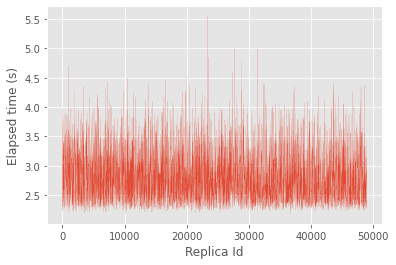

In [9]:
ax=df_inference['elapsed'].plot(linewidth=0.1)
ax.set_ylabel('Elapsed time (s)')
ax.set_xlabel('Replica Id')

Text(0.5, 0, 'Elapsed time (s)')

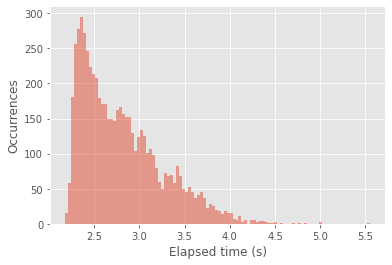

In [10]:
ax = df_inference['elapsed'].plot.hist(bins=102, alpha=0.5)
ax.set_ylabel('Occurrences')
ax.set_xlabel('Elapsed time (s)')

## GPU/CPU

In [11]:
base = min(df_inference['stime']) - datetime.timedelta(seconds=30)
time_list = [base + datetime.timedelta(seconds=x) for x in range(800)]

In [12]:
def gen_rdata(df):
    rdata_ddmd = []
    cnt = 0
    for i in time_list:
        tmp = df[(df['stime'] <= i)]
        tmpid = (tmp.id)
        tmp2 = df[df['stime'] + pd.to_timedelta(df['elapsed'], unit='s') >= i]
        tmp2id = (tmp2.id)
        merged = (list(tmpid) + list(tmp2id))
        active = {x: count for x, count in Counter(merged).items() if count >= 2}
        rdata_ddmd.append([i, len(active)])
    return rdata_ddmd

In [13]:
df_preprocess_traj  = df_ddmd[df_ddmd['step']=='Start preprocess_traj']
rdata_preprocess_traj = gen_rdata(df_preprocess_traj)
df_rdata_preprocess_traj = pd.DataFrame(rdata_preprocess_traj)

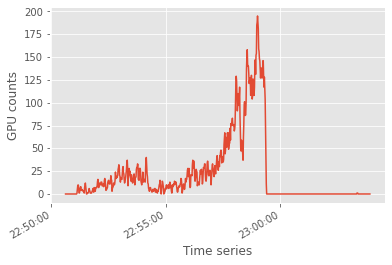

In [14]:
rdata_inference = gen_rdata(df_inference)
df_rdata_inference = pd.DataFrame(rdata_inference)
ax=df_rdata_inference.plot(x=0, legend=False)
formatter = mdates.DateFormatter('%T')
plt.gca().xaxis.set_major_formatter(formatter)
ax.set_ylabel('GPU counts')
ax.set_xlabel('Time series')
plt.show()

# WESTPA performance

In [16]:
df_westpa=pd.read_csv('westpa_stats.csv',names=['id','ns/day','stime','elapsed'])
df_westpa['stime'] = pd.to_datetime(df_westpa['stime'])

In [17]:
df_westpa

,id,ns/day,stime,elapsed
0,001689,33.52,2021-10-07 22:48:22,267.0
1,005916,33.85,2021-10-07 22:49:24,265.0
2,005635,34.03,2021-10-07 22:49:24,263.0
3,000799,33.84,2021-10-07 22:49:24,265.0
4,003647,33.65,2021-10-07 22:48:22,266.0
...,...,...,...,...
5027,001208,34.04,2021-10-07 22:48:54,262.0
5028,004122,33.82,2021-10-07 22:50:26,264.0
5029,001060,33.68,2021-10-07 22:48:57,265.0
5030,000302,33.99,2021-10-07 22:48:16,263.0


In [18]:
base = min(df_westpa['stime']) - datetime.timedelta(seconds=30)
time_list = [base + datetime.timedelta(seconds=x) for x in range(600)]

In [20]:
last_tx = df_westpa[df_westpa['stime']==max(df_westpa['stime'])]['elapsed']
max(df_westpa['stime']), (max(df_westpa['stime']) + pd.to_timedelta(last_tx,unit='s')), max(rdata)

(Timestamp('2021-10-07 22:51:31'),
 3025   2021-10-07 22:55:56
 Name: elapsed, dtype: datetime64[ns],
 [Timestamp('2021-10-07 22:55:36'), 27])

Text(0.5, 0, 'Time series')

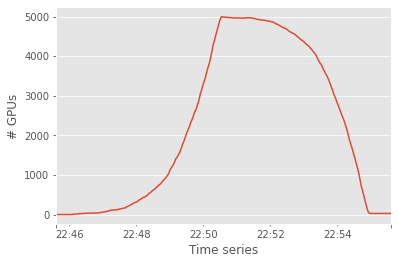

In [31]:
rdata = gen_rdata(df_westpa)
df_westpa_resource = pd.DataFrame(rdata)

ax=df_westpa_resource.plot(x=0, legend=False)
ax.set_ylabel('# GPUs')
ax.set_xlabel('Time series')

# Amber performance

In [24]:
print("{:.02f}{}{:.02f} ns/day".format(df_westpa['ns/day'].mean(),u"\u00B1", df_westpa['ns/day'].std()))

33.85±0.19 ns/day


## Time to execution in average

In [25]:
print("{:.02f}{}{:.02f} s".format(df_westpa['elapsed'].mean(),u"\u00B1", df_westpa['elapsed'].std()))

263.96±1.63 s


## Total time to execution

In [26]:
last_tx = df_westpa[df_westpa['stime']==max(df_westpa['stime'])]['elapsed']
dif = (max(df_westpa['stime'])-min(df_westpa['stime'])).total_seconds()
print("{}s".format(dif + float(last_tx)))

589.0s


Text(0.5, 0, 'ns/day')

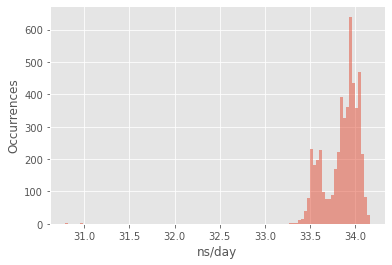

In [36]:
ax=df_westpa['ns/day'].plot.hist(bins=102, alpha=0.5)
ax.set_ylabel('Occurrences')
ax.set_xlabel('ns/day')

Text(0.5, 0, 'Elapsed time (s)')

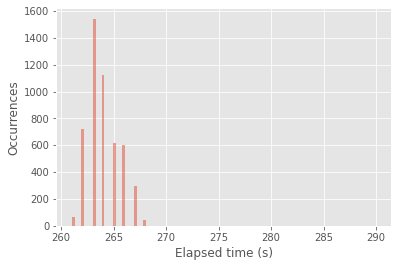

In [39]:
ax=df_westpa['elapsed'].plot.hist(bins=102, alpha=0.5)
ax.set_ylabel('Occurrences')
ax.set_xlabel('Elapsed time (s)')